In [1]:
pwd

'/Users/kellymclean/Parkinsons'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

In [3]:
import numpy as np
from skimage.io import imread
from skimage.util import montage as montage2d
import pandas as pd
from pathlib import Path
data_dir = Path('/Users/kellymclean/Parkinsons/drawings/')

In [ ]:
path = '/Users/kellymclean/Parkinsons/drawings/'

In [4]:
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df['activity'] = draw_df['path'].map(lambda x: x.parent.parent.parent.stem)
print(draw_df.shape, 'images loaded')
draw_df.sample(3)

(204, 5) images loaded


,path,img_id,disease,validation,activity
156,/Users/kellymclean/Parkinsons/drawings/wave/tr...,V03PO03,parkinson,training,wave
68,/Users/kellymclean/Parkinsons/drawings/spiral/...,V05PE02,parkinson,training,spiral
99,/Users/kellymclean/Parkinsons/drawings/spiral/...,V14PE03,parkinson,testing,spiral


In [5]:
def fixed_imread(in_path, resize=True):
    """read images, invert and scale them"""
    c_img = 1.0-imread(in_path, as_gray=True)
    max_dim = np.max(c_img.shape)
    if not resize:
        return c_img
    if c_img.shape==(256, 256):
        return c_img
    if max_dim>256:
        big_dim = 512
    else:
        big_dim = 256
        
    out_img = np.zeros((big_dim, big_dim), dtype='float32')
    c_offset = (big_dim-c_img.shape[0])//2
    d_offset = c_img.shape[0]+c_offset
    
    e_offset = (big_dim-c_img.shape[1])//2
    f_offset = c_img.shape[1]+e_offset
    out_img[c_offset:d_offset, e_offset:f_offset] = c_img[:(d_offset-c_offset), :(f_offset-e_offset)]
    return out_img

ValueError: all input arrays must have the same shape

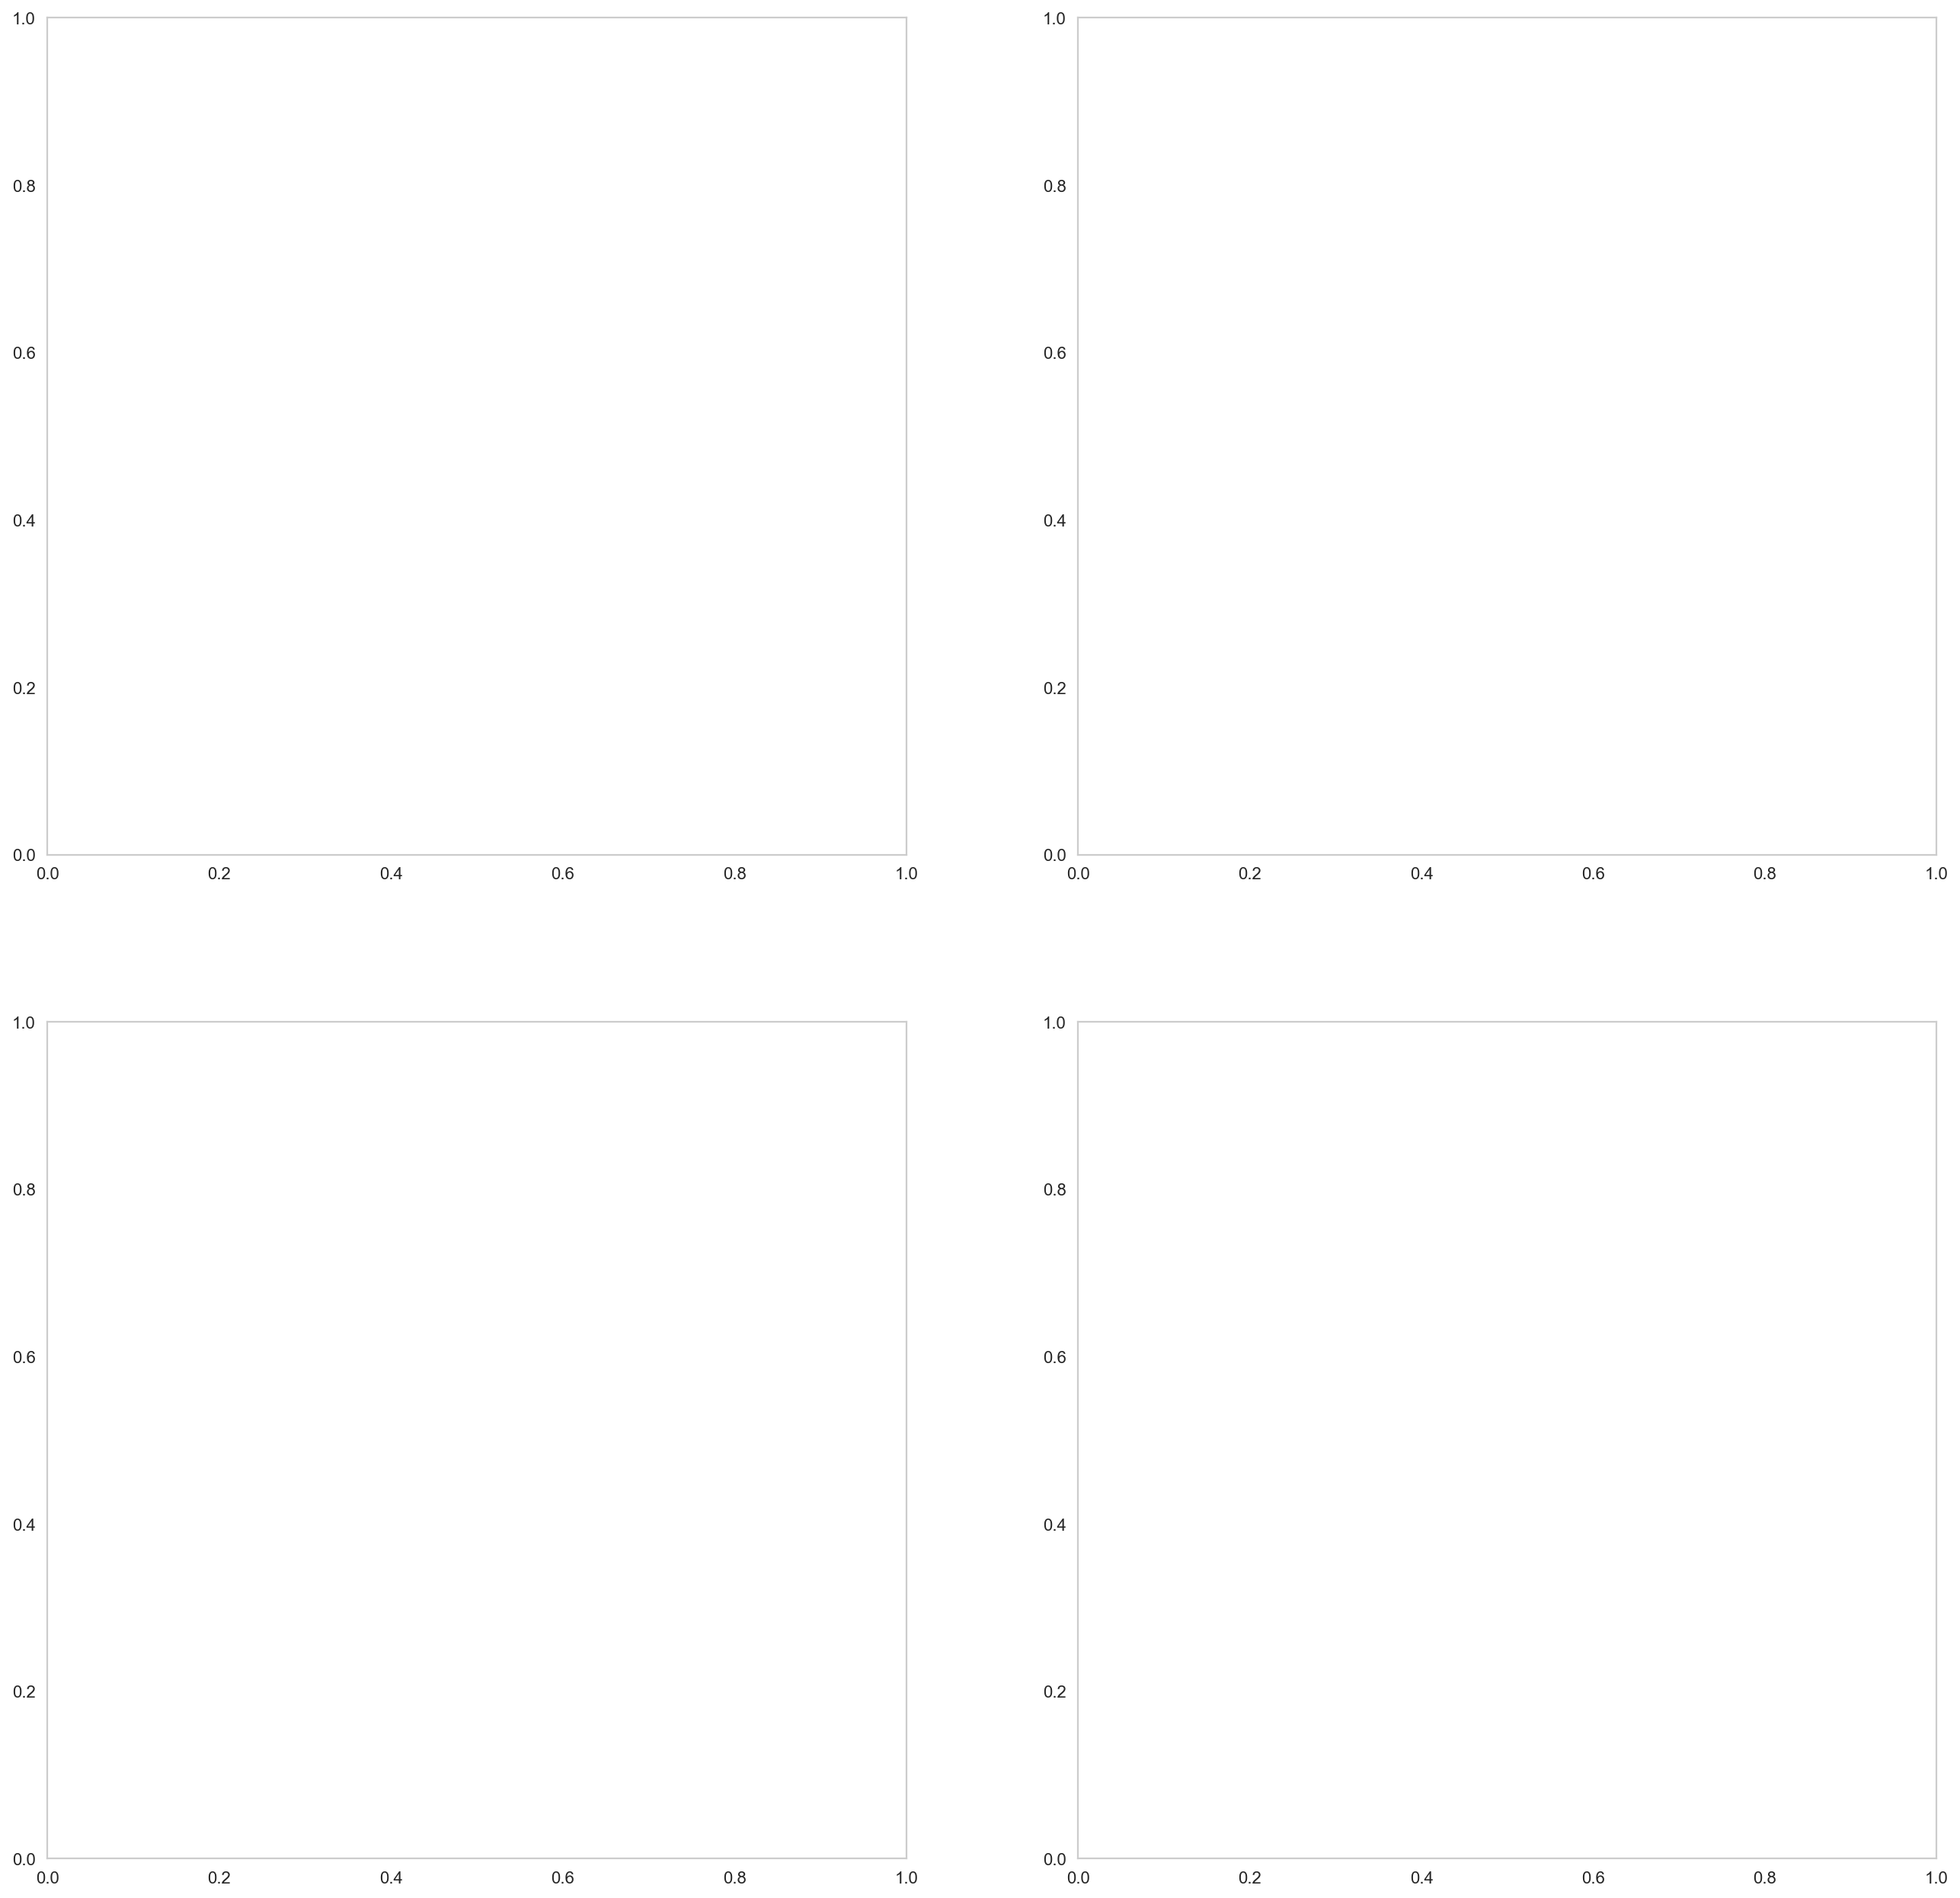

In [6]:
fig, m_axs = plt.subplots(2, 2, figsize=(20, 20))
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([fixed_imread(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

In [7]:
from skimage.io import imread
from skimage.util import montage as montage2d
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk
import numpy as np
def process_imread(in_path, resize=True):
    """read images, invert and scale them"""
    c_img = 1.0-imread(in_path, as_gray=True)
    max_dim = np.max(c_img.shape)
    if not resize:
        return c_img
    if c_img.shape==(256, 256):
        return c_img
    if max_dim>256:
        big_dim = 512
    else:
        big_dim = 256
    """ pad with zeros and center image, sizing to either 256 or 512"""   
    out_img = np.zeros((big_dim, big_dim), dtype='float32')
    c_offset = (big_dim-c_img.shape[0])//2
    d_offset = c_img.shape[0]+c_offset
    
    e_offset = (big_dim-c_img.shape[1])//2
    f_offset = c_img.shape[1]+e_offset
    out_img[c_offset:d_offset, e_offset:f_offset] = c_img[:(d_offset-c_offset), :(f_offset-e_offset)]
    return out_img
def read_and_thresh(in_path, resize=True):
    c_img = process_imread(in_path, resize=resize)
    c_img = (255*c_img).clip(0, 255).astype('uint8')
    c_img = median(c_img, disk(1))
    c_thresh = thresh_func(c_img)
    return c_img>c_thresh

In [8]:
from skimage.morphology import label as sk_label
def label_sort(in_img, cutoff=0.01):
    total_cnt = np.sum(in_img>0)
    lab_img = sk_label(in_img)
    new_image = np.zeros_like(lab_img)
    remap_index = []
    for k in np.unique(lab_img[lab_img>0]):
        cnt = np.sum(lab_img==k) # get area of labelled object
        if cnt>total_cnt*cutoff:
            remap_index+=[(k, cnt)]
    sorted_index = sorted(remap_index, key=lambda x: -x[1]) # reverse sort - largest is first
    for new_idx, (old_idx, idx_count) in enumerate(sorted_index, 1): #enumerate starting at id 1
        new_image[lab_img==old_idx] = new_idx
    return new_image

In [9]:
from skimage.morphology import medial_axis
from skimage.morphology import skeletonize
def stroke_thickness_img(in_img):
    skel, distance = medial_axis(in_img, return_distance=True)
    skeleton = skeletonize(in_img)
    # Distance to the background for pixels of the skeleton
    return distance * skeleton

# Filter and Segment

We can filter and segment the images in order to extract the drawings more clearly as just drawing pixels and noise

ValueError: all input arrays must have the same shape

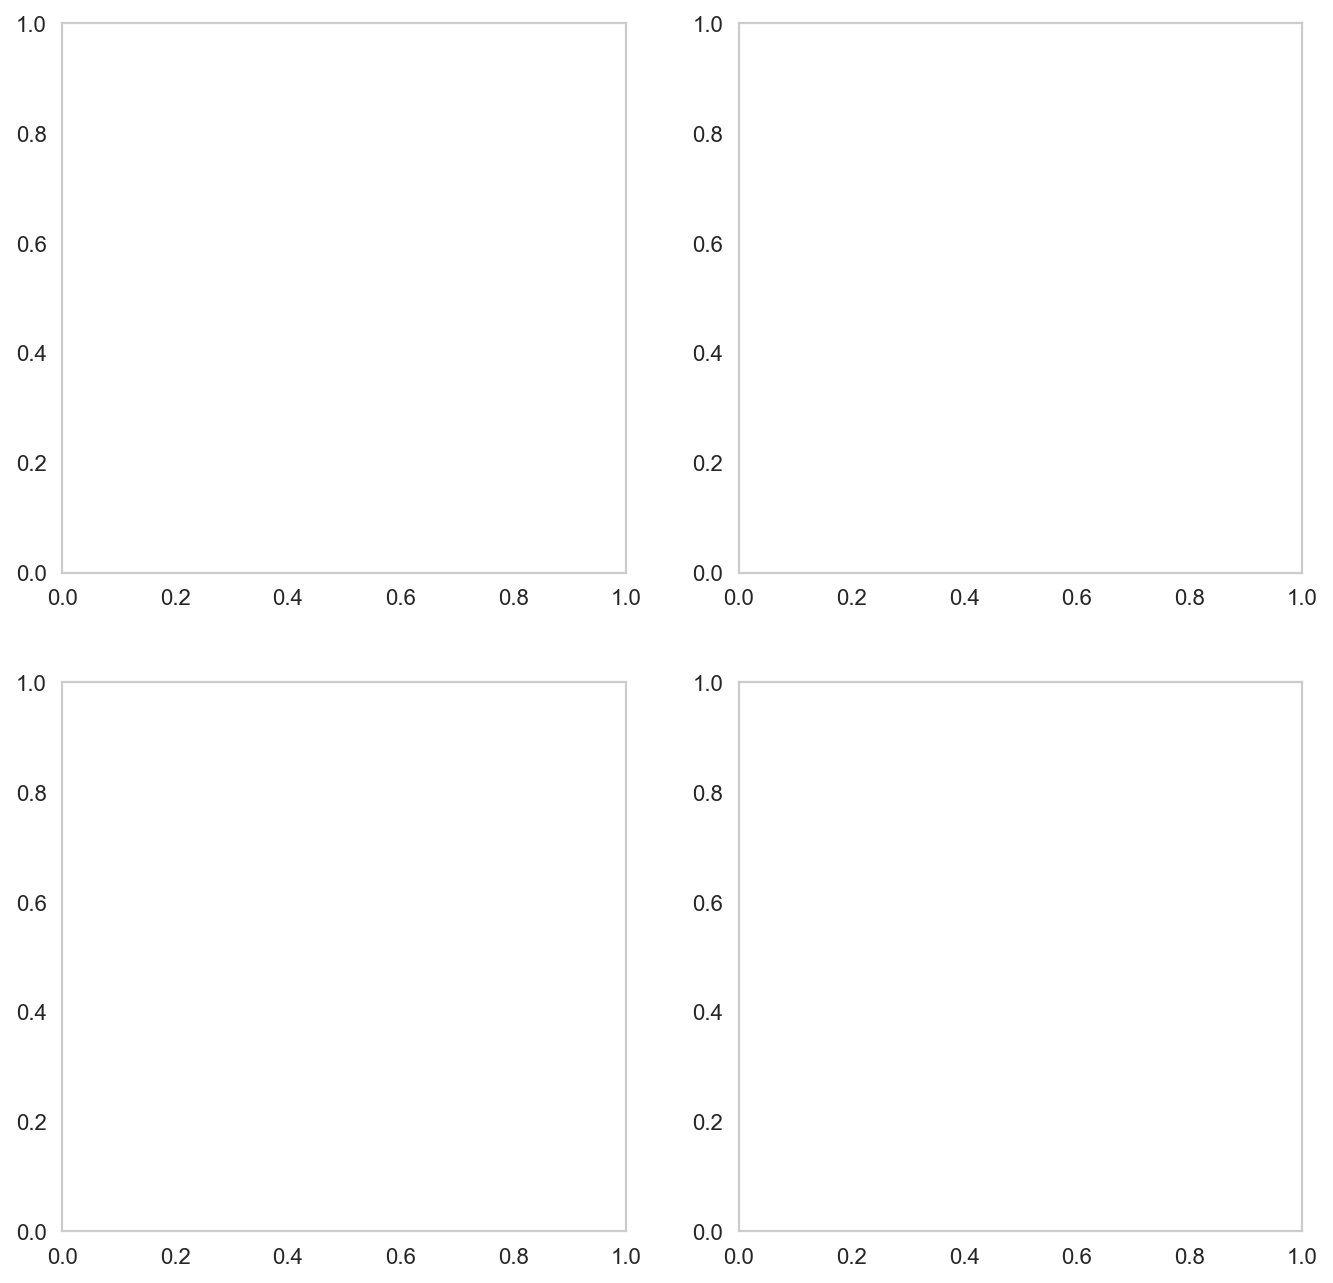

In [10]:
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk, opening, diamond

def read_and_thresh(in_path, resize=True):
    c_img = fixed_imread(in_path, resize=resize)
    c_img = (255*c_img).clip(0, 255).astype('uint8')
    c_img = median(c_img, disk(2))
    c_thresh = thresh_func(c_img)
    return c_img>c_thresh
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([read_and_thresh(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

In [11]:
%%time
# run all images
draw_df['thresh_img'] = draw_df['path'].map(lambda x: read_and_thresh(x, resize=False))

CPU times: user 4.66 s, sys: 145 ms, total: 4.8 s
Wall time: 4.98 s


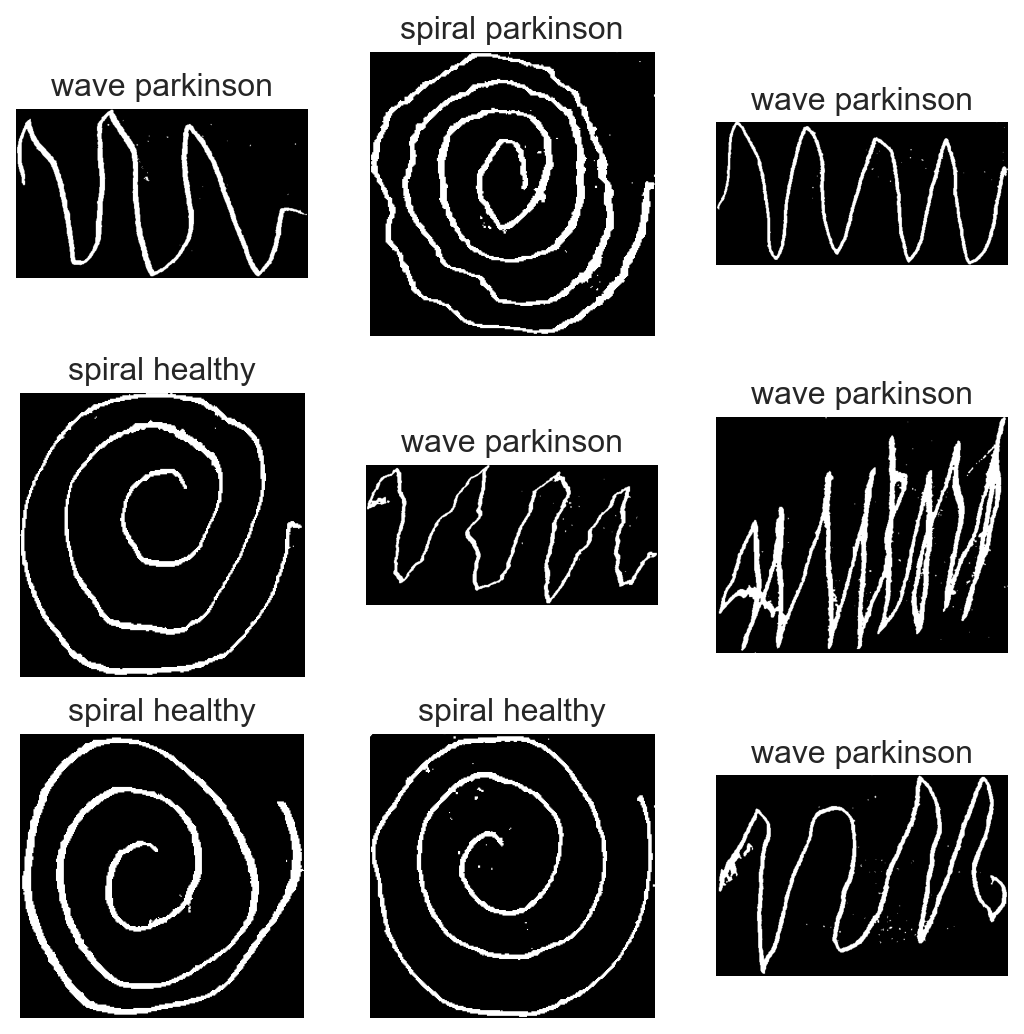

In [12]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    c_ax.imshow(c_row['thresh_img'], cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

In [13]:
from skimage.morphology import label
from skimage.morphology import closing
def label_sort(in_img, cutoff=0.1):
    total_cnt = np.sum(in_img>0)
    lab_img = label(in_img)
    new_image = np.zeros_like(lab_img)
    remap_index = []
    for k in np.unique(lab_img[lab_img>0]):
        cnt = np.sum(lab_img==k)
        if cnt>total_cnt*cutoff:
            remap_index+=[(k, cnt)]
    sorted_index = sorted(remap_index, key=lambda x: -x[1])
    for new_idx, (old_idx, idx_count) in enumerate(sorted_index, 1):
        new_image[lab_img==old_idx] = new_idx
    return new_image

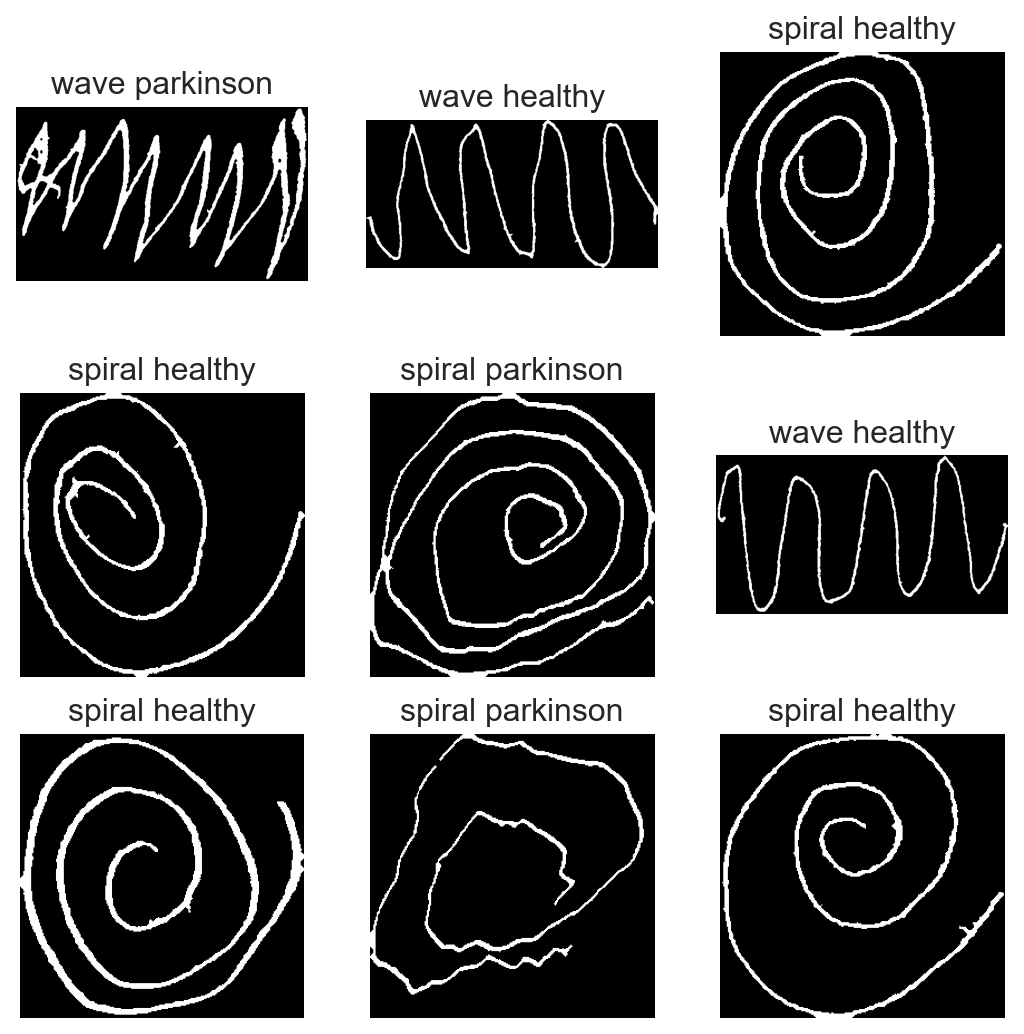

In [14]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    clean_img = closing(label_sort(c_row['thresh_img'])>0, disk(2))
    c_ax.imshow(clean_img, cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

In [15]:
%%time
draw_df['clean_img'] = draw_df['thresh_img'].map(lambda x: closing(label_sort(x)>0, disk(2)))

CPU times: user 1.73 s, sys: 21.3 ms, total: 1.75 s
Wall time: 1.76 s


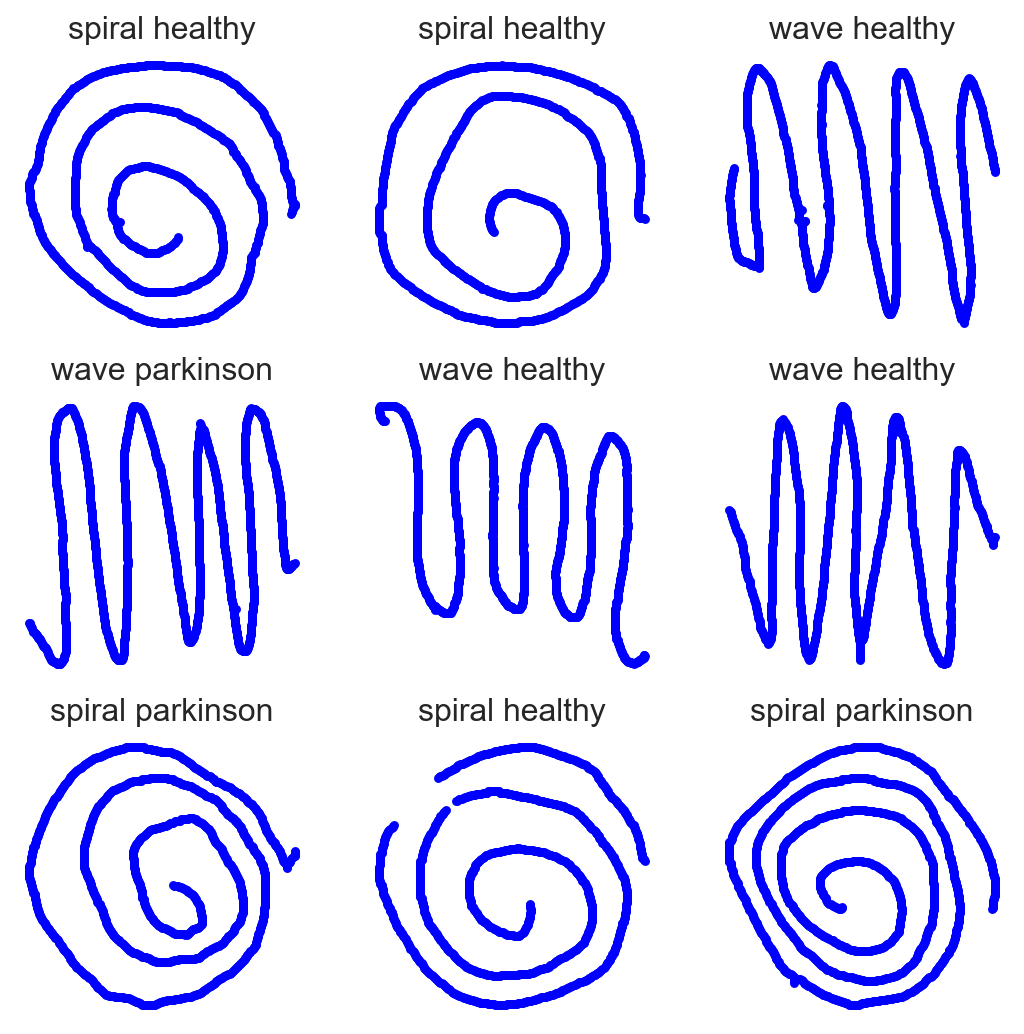

In [16]:
from skimage.morphology import skeletonize

fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    
    c_ax.plot(skel_x, skel_y, 'b.')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

# Convert to table

We convert all of the detected skeleton points into a table and combine all of the results together

In [17]:
all_row_list = []
for _, c_row in draw_df.iterrows():
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    for x, y in zip(skel_x, skel_y):
        d_row = dict(**{k: v for k,v in c_row.items() if len(np.shape(v))<1})
        d_row['x'] = x
        d_row['y'] = y
        all_row_list += [d_row]

In [18]:
all_row_df = pd.DataFrame(all_row_list)
all_row_df.sample(3)

,path,img_id,disease,validation,activity,x,y
97595,/Users/kellymclean/Parkinsons/drawings/spiral/...,V15PE02,parkinson,training,spiral,0.707031,0.191406
137050,/Users/kellymclean/Parkinsons/drawings/spiral/...,V06PE01,parkinson,testing,spiral,0.472656,0.906250
278866,/Users/kellymclean/Parkinsons/drawings/wave/te...,V55HO08,healthy,testing,wave,0.236328,0.973568


# Overlay drawings on same axis for comparison

Plotting the skeleton pixels as points, and rescaling we can overlay all of the images on top of each other for better visualization. The healthy patients are significantly more consistent than the Parkinson's.

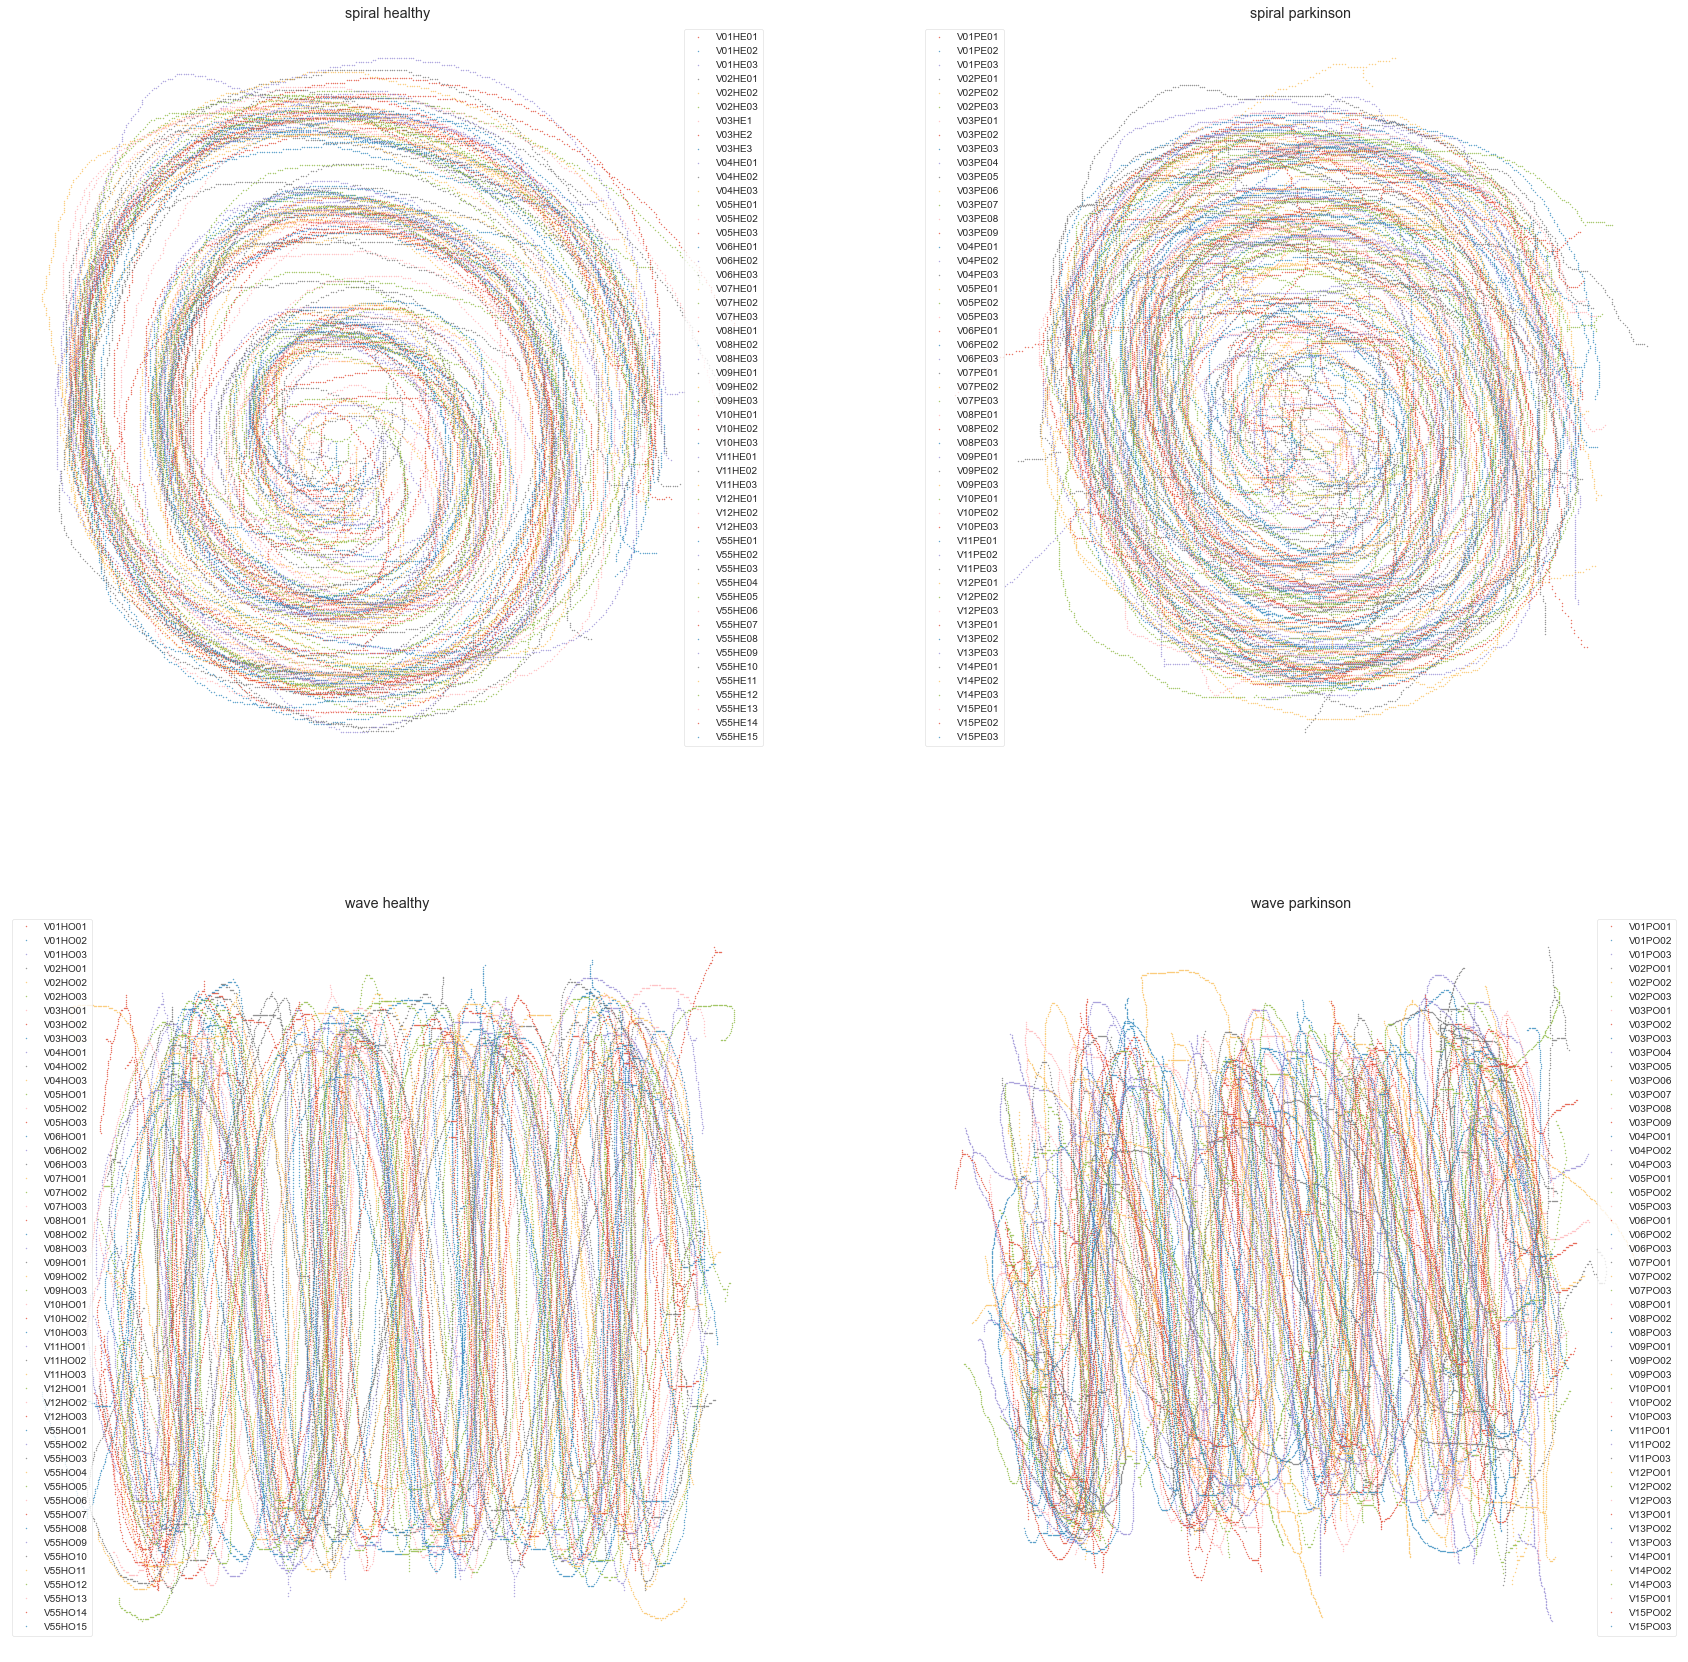

In [19]:
fig, m_axs = plt.subplots(2, 2, figsize=(30, 30), dpi=72)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), all_row_df.groupby(['activity', 'disease'])):
    for c_id, d_rows in c_rows.groupby('img_id'):
        mean_std = np.mean([d_rows['x'].std(), d_rows['y'].std()])
        c_ax.plot((d_rows['x']-d_rows['x'].mean())/mean_std, 
                  (d_rows['y']-d_rows['y'].mean())/mean_std, '.', label=c_id, ms=0.75)
    c_ax.legend()
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

# Next Steps

Try and order the curves and get realistic (if possibly inaccurate) trajectories for the pen movement
Quantify the pressure by looking at the thickness of the skeleton at specific points.
Start to quantify the 'jigglyness' of the motion (fourier analysis of the time series?, differential motion?)